# Adding and Managing Memory in LangGraph

Don't have a specific tutorial to go through on this one, so I will just grab information from multiple articles and documents in langchain-ai github.

## Basic Chatbot
Need something basic in order to add memory to track.

Using Harish Neel's video series to walk through this for the first time.
YouTube video #25 of the series [here](https://www.youtube.com/watch?v=KU_FDwwL5_s)

In [3]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, add_messages, END
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

llm = init_chat_model("ollama:qwen2.5:32b", temperature=0)

In [ ]:
class BasicChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def chatbot(state:BasicChatState):
    return {
        "messages": [llm.invoke(state["messages"])]
    }

In [ ]:
graph = StateGraph(BasicChatState)

graph.add_node("chatbot", chatbot)
graph.set_entry_point("chatbot")
graph.add_edge("chatbot", END)

In [7]:
app = graph.compile()

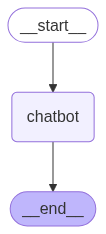

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
input_greeting = {
    "messages": [
        {"role": "user", "content": "Hi! i am Tom"}
    ]
}

response = app.invoke(input_greeting)
print("Bot:", response["messages"][-1].content)

Bot: Hello Bob! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [ ]:
input_question = {
    "messages": [
        {"role": "user", "content": "what's my name?"}
    ]
}

response = app.invoke(input)
print("Bot:", response["messages"][-1].content)

Bot: I don't have access to information about specific users unless you provide it to me during our conversation. Could you tell me your name if you're comfortable sharing it?


## Add tools

Video #26 found [here](https://www.youtube.com/watch?v=FYxvh5YQniQ)

In [12]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [14]:
search_tool.invoke("What's a node in LangGraph?")

{'query': "What's a node in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. The state of this graph by default contains concepts that should be familiar to you if you've used LangChain agents: `input`, `chat_history`, `intermediate_steps` (and `agent_outcome` to represent the most recent agent outcome)",
   'score': 0.7634314,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction-t

In [13]:
llm_with_tools = llm.bind_tools(tools=tools)

In [15]:
def chatbot_with_tools(state:BasicChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
}

In [ ]:
def tools_router(state:BasicChatState):
    last_message = state["messages"][-1]

    # Check if last message is a tool call attribute
    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

In [19]:
from langgraph.prebuilt import ToolNode

tools_node = ToolNode(tools=tools)

In [22]:
from langgraph.prebuilt import tools_condition

graph_with_tools = StateGraph(BasicChatState)

graph_with_tools.add_node("chatbot", chatbot_with_tools)
graph_with_tools.add_node("tools_node", tools_node)
graph_with_tools.set_entry_point("chatbot")

graph_with_tools.add_conditional_edges("chatbot", tools_condition, {"tools": "tools_node", END: END})
graph_with_tools.add_edge("tools_node", "chatbot")

In [24]:
app_with_tools = graph_with_tools.compile()

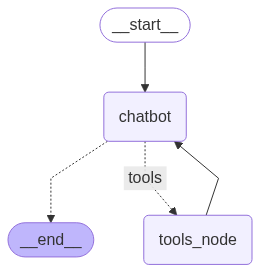

In [25]:
display(Image(app_with_tools.get_graph().draw_mermaid_png()))

In [26]:
input_greeting = {
    "messages": [
        {"role": "user", "content": "Hi! i am Tom"}
    ]
}

response = app_with_tools.invoke(input_greeting)
print("Bot:", response["messages"][-1].content)

Bot: Hello Tom! How can I assist you today?


In [27]:
input_tool_question = {
    "messages": [
        {"role": "user", "content": "What's a node in LangGraph?"}
    ]
}

response = app_with_tools.invoke(input_tool_question)
print("Bot:", response["messages"][-1].content)

Bot: A node in LangGraph represents a step in your computation within a stateful graph. Each node updates the state of the graph, which is maintained as key-value pairs and includes concepts like `input`, `chat_history`, `intermediate_steps`, and `agent_outcome`. After adding nodes, you can connect them with edges to create the desired computational flow. For example, in an agent runtime setup, a model node might be configured to run after a tool node has been executed. This structure allows for dynamic and conditional execution paths based on the current state of the graph.


In [28]:
response

{'messages': [HumanMessage(content="What's a node in LangGraph?", additional_kwargs={}, response_metadata={}, id='06aa9fca-5f61-4294-8978-007defebe138'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-07-09T21:37:57.2534145Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11675091400, 'load_duration': 28332800, 'prompt_eval_count': 980, 'prompt_eval_duration': 1588828400, 'eval_count': 25, 'eval_duration': 10053837200, 'model_name': 'qwen2.5:32b'}, id='run--f2730e11-2766-4355-93d7-b92a986c0f7b-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'node in LangGraph'}, 'id': 'ae32f5e6-79ef-4920-94e9-3b00163137d4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 980, 'output_tokens': 25, 'total_tokens': 1005}),
  ToolMessage(content='{"query": "node in LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.langchain.dev/langgraph/", "title": "LangGraph - L

## With Memory
- Harish Video #27 found [here](https://www.youtube.com/watch?v=QTaou6alCL0)
- Official documentation from LangChain-ai [here](https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/)

In [29]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

app_with_memory = graph_with_tools.compile(checkpointer=checkpointer)

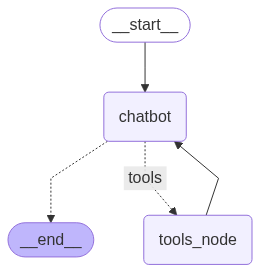

In [30]:
display(Image(app_with_memory.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "1"}}

In [32]:
user_input = "Hello! I'm Tom"

events = app_with_memory.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello! I'm Tom
================================== Ai Message ==================================

Hello Tom! How can I assist you today?


In [33]:
user_input = "Do you remember my name?"

events = app_with_memory.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Tom. How can I help you today, Tom?


In [49]:
messages = app_with_memory.get_state(config=config)

for message in messages.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello! I'm Tom
================================== Ai Message ==================================

Hello Tom! How can I assist you today?
================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Tom. How can I help you today, Tom?


## With SqliteSaver Checkpointer
Video #28 found [here](https://www.youtube.com/watch?v=xK8g1A5Plvk)

In [50]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)



In [51]:
app_with_sqlite = graph_with_tools.compile(checkpointer=memory)

In [ ]:
config_sqlite = {"configurable": {"thread_id": "2"}}

In [ ]:
user_input = "Hello! I'm Tom"

events = app_with_sqlite.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_sqlite,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()